# Data Manipulation Demo

## Reannotate CSV

In [1]:
import pandas as pd

In [2]:
ann_train = '../Data/ISIC2017/ISIC-2017_Training_Add_Part3_GroundTruth.csv'

df_train = pd.read_csv(ann_train)
df_train.head()

,image_id,nodiease,melanoma,seborrheic_keratosis
0,ISIC_0000000,1,0,0
1,ISIC_0000001,1,0,0
2,ISIC_0000002,0,1,0
3,ISIC_0000003,1,0,0
4,ISIC_0000004,0,1,0


In [3]:
# 使扩充的training set标注格式与valid、test一致
del df_train['nodiease']
df_train.to_csv('../Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv', index=False)
df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


## Statistical Analysis

In [1]:
import sys
sys.path.append(r"..")

import utils

ann_train = utils.Annotation('../Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv')
ann_train.df.head()

,image_id,label
0,ISIC_0000000,2
1,ISIC_0000001,2
2,ISIC_0000002,0
3,ISIC_0000003,2
4,ISIC_0000004,0


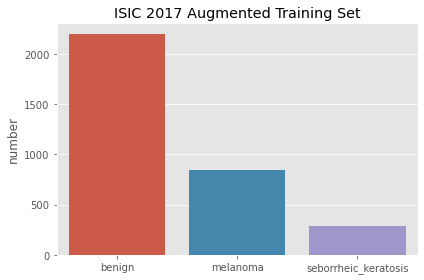

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

counts = ann_train.df.label.value_counts()
ax = sns.barplot(x=[ann_train.label_dict[i] for i in counts.index], y=counts)
ax.set_ylabel('number')
ax.set_title('ISIC 2017 Augmented Training Set')
plt.tight_layout()
plt.show()
plt.style.use ('default')

## Extract Resized Patches

randomly extracted 60 rectangular image patches from the central part of each image at different scales (1/5, 2/5, 3/5, and 4/5 of original image size) on both official and extra training images, and then resized them to 224×224 using the bilinear interpolation

In [3]:
from tqdm import tqdm
import os
from PIL import Image
from torchvision import transforms
import utils

img_dir = '../Data/ISIC2017/ISIC-2017-Aug_Training_Data'
save_dir = '../Data/Training_Patch'

if not os.path.exists(save_dir):
      os.makedirs(save_dir)


def rescale_crop(image, scale, sample_num):
    image_list = []
    h, w = image.size
    if scale == 1:
        trans = transforms.Resize((224, 224))
    elif scale > 1/2:
        trans = transforms.Compose([
        # transforms.RandomResizedCrop((int(h * scale), int(w * scale)), (scale, scale), ratio=(1, 1,)),
        # transforms.CenterCrop((int(h * scale + 100 * (1 - scale)), int(w * scale + 100 * (1 - scale)))),
        transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge'),
        transforms.Resize((224, 224))
    ])
    else:
        trans = transforms.Compose([
        # transforms.RandomResizedCrop((int(h * scale), int(w * scale)), (scale, scale), ratio=(1, 1,)),
        transforms.CenterCrop((int(h - h * (1 - scale)**2), int(w - w * (1 - scale)**2))),
        transforms.RandomCrop((int(h * scale), int(w * scale)), pad_if_needed=True, padding_mode='edge'),
        transforms.Resize((224, 224))
    ])
    for _ in range(sample_num):
        img = trans(image)
        image_list.append(img)
    return image_list
            

In [4]:
sample_num = 15

for step, id in tqdm(ann_train.df['image_id'].items(), desc="Progress", leave=True, total=len(ann_train.df)):
    ori_path = os.path.join(img_dir, id + '.jpg')
    image = Image.open(ori_path)
    
    for j, scale in enumerate([1/5, 2/5, 3/5, 4/5]):
        patches = rescale_crop(image, scale, sample_num)
        for i in range(sample_num):
            id_patch = id + '_' + '{:02d}'.format(i+j*sample_num)
            save_path = os.path.join(save_dir, id_patch + '.jpg')
            patches[i].save(save_path)

Progress: 100%|██████████| 3320/3320 [8:19:53<00:00,  9.03s/it]     


## DataLoader Demo

In [1]:
import sys
sys.path.append(r"..")

import utils

pth_train = '../Data/ISIC2017/Training_Patch'

ann_train = utils.Annotation('../Data/ISIC2017/ISIC-2017_Training_Aug_Part3_GroundTruth.csv')

In [2]:
from torchvision import transforms
from torch.utils import data

transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ])

# augmentation transform
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomAffine(10, scale=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

In [3]:
# create train dataset
train_data = utils.Data(ann_train.df, pth_train, 60, transform=transform_train)
train_loader = data.DataLoader(train_data, batch_size=6, shuffle=True)

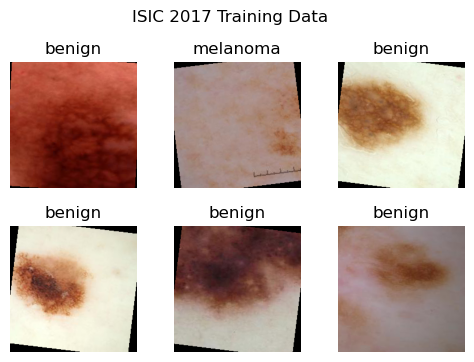

In [4]:
x, y = next(iter(train_loader))
labels = ann_train.to_names(y)

utils.show_samples(x, labels, 2, 3, "ISIC 2017 Training Data")